Let's try to come up with a model that can predict **Maximum Temperature** based on one or more factors (Rainfall, Sunshine, Windspeed, Humidity, Cloud, Visibility, Pressure etc). Dataset source: Pearson Large Dataset.

In [3]:
!pip install xlrd==1.2.0
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load raw data file from one of these sources:
1.   Upload local .csv file for Camborne1987 dataset (loads fine)
2.   Upload full local Excel file (loads fine)
3.   Load full Excel file from public URL (throwing an Assertion error)

In [7]:
#@title Code for loading raw dataset
pd.options.display.max_rows = 5
pd.options.display.float_format = "{:.1f}".format

#training_df = pd.read_csv(io.BytesIO(uploaded['Camborne1987.csv']), header=None)
#training_df = pd.read_excel(io.BytesIO(uploaded['DataSet.xls']),sheet_name=1,header=None,skiprows=6,usecols='A:O',nrows=184)
#training_df = pd.read_excel("https://docs.google.com/spreadsheets/d/1YE1MgzQ4YD4Pu_1GZMVLRVZ5iMC3Bw42/edit?usp=sharing&ouid=111319643281971974217&rtpof=true&sd=true",sheet_name=1,header=None,skiprows=6,usecols='A:O',nrows=184)

training_df = pd.read_excel('/content/sample_data/DataSet.xls',sheet_name=1,header=None,skiprows=6,usecols='A:O',nrows=184)
#we can load other Sheets (different locations) if needed
#for i in range(2,11):
#  df = pd.read_excel('/content/sample_data/DataSet.xls',sheet_name=i,header=None,skiprows=6,usecols='A:O',nrows=184)
#  training_df = pd.concat([training_df, df])

Clean raw data, add Header row and replace tr (traces of rainfall) with 0.05, NaN with 0, scale down large values

In [8]:
#@title Perform data cleanup and scaling
training_df.columns = ["Date","Temperature","Rainfall","Sunshine","Windspeed","Windspeed_Beaufort","Gust_kn","Humidity","Cloud","Visibility","Pressure","Wind_Direction","Cardinal_Direction","Max_Gust","Cardinal_Direction2"]
training_df["Rainfall"] = training_df["Rainfall"].replace("tr", 0.025)
training_df = training_df.replace(np.nan, 0)

training_df["Visibility"] /= 200
training_df["Pressure"] /= 100
training_df["Humidity"] /= 10

#print(training_df.shape)
print(training_df.head())
#training_df.describe()

        Date  Temperature  Rainfall  Sunshine  Windspeed Windspeed_Beaufort  \
0 1987-05-01         10.7       3.1       0.0        0.0                  0   
1 1987-05-02          8.8       0.1       0.0        0.0                  0   
2 1987-05-03          8.1       0.0       0.0        0.0                  0   
3 1987-05-04          8.2       0.0       0.0        0.0                  0   
4 1987-05-05          9.8       0.0       0.0        0.0                  0   

   Gust_kn  Humidity  Cloud  Visibility  Pressure  Wind_Direction  \
0      0.0      10.0      7        10.0      10.2             360   
1      0.0       9.1      3        16.0      10.2             320   
2      0.0       7.7      5        18.0      10.3             350   
3      0.0       8.3      5        20.5      10.4             350   
4      0.0       8.6      5        13.5      10.4              10   

  Cardinal_Direction  Max_Gust Cardinal_Direction2  
0                  N      20.0                 NNE  
1   

Let's plot the scaled dataset on a chart

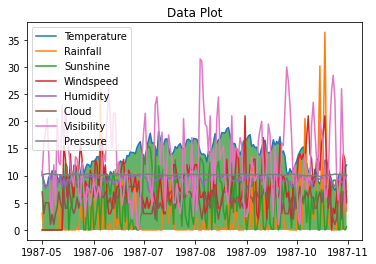

In [9]:
#@title Plotting our Dataset
from datetime import date
x = np.array(training_df['Date'], dtype=date)
y = np.array(training_df['Temperature'], dtype=float)
z = np.array(training_df['Rainfall'], dtype=float)
a = np.array(training_df['Sunshine'], dtype=float)
b = np.array(training_df['Windspeed'], dtype=float)
c = np.array(training_df['Humidity'], dtype=float)
d = np.array(training_df['Cloud'], dtype=float)
e = np.array(training_df['Visibility'], dtype=float)
f = np.array(training_df['Pressure'], dtype=float)

plt.plot(x, y, label="Temperature")
plt.plot(x, z, label="Rainfall")
plt.plot(x, a, label="Sunshine")
plt.plot(x, b, label="Windspeed")
plt.plot(x, c, label="Humidity")
plt.plot(x, d, label="Cloud")
plt.plot(x, e, label="Visibility")
plt.plot(x, f, label="Pressure")

plt.fill_between(x, y, 0, where=(y > 0), facecolor='g', alpha=0.6)
plt.title("Data Plot")
plt.legend()
plt.show()

Define functions that build and train a Model

In [10]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model        

def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""
  history = model.fit(x=np.array(df[feature], dtype=float),
                      y=np.array(df[label], dtype=float),
                      batch_size=batch_size,
                      epochs=epochs)
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]
  return trained_weight, trained_bias, epochs, rmse

print("Defined the build_model and train_model functions.")

Defined the build_model and train_model functions.


Define Plotting functions

In [11]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 50 random training examples."""
  plt.xlabel(feature)
  plt.ylabel(label)
  random_examples = training_df.sample(n=50,replace=True)  #using replace=True because of small dataset
  plt.scatter(random_examples[feature], random_examples[label])
  x0 = 0
  y0 = trained_bias
  x1 = training_df[feature].max()
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')
  plt.show()

def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")
  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

def plot_the_loss_curve2(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


Model Temperature (label) using Sunshine (feature)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
8/8 [==============================] - 1s 3ms/step - loss: 409.8263 - root_mean_squared_error: 20.2442
Epoch 2/250
8/8 [==============================] - 0s 3ms/step - loss: 328.4680 - root_mean_squared_error: 18.1237
Epoch 3/250
8/8 [==============================] - 0s 3ms/step - loss: 270.9744 - root_mean_squared_error: 16.4613
Epoch 4/250
8/8 [==============================] - 0s 3ms/step - loss: 223.1611 - root_mean_squared_error: 14.9386
Epoch 5/250
8/8 [==============================] - 0s 3ms/step - loss: 184.5433 - root_mean_squared_error: 13.5847
Epoch 6/250
8/8 [==============================] - 0s 2ms/step - loss: 151.9884 - root_mean_squared_error: 12.3284
Epoch 7/250
8/8 [==============================] - 0s 3ms/step - loss: 124.4256 - root_mean_squared_error: 11.1546
Epoch 8/250
8/8 [==============================] - 0s 2ms/step - loss: 101.7633 - root_mean_squared_error: 10.0878
Epoch 9/250
8/8 [==============================] - 0s 3ms/step - loss: 84.0098 -

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


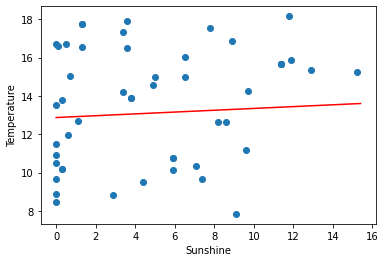

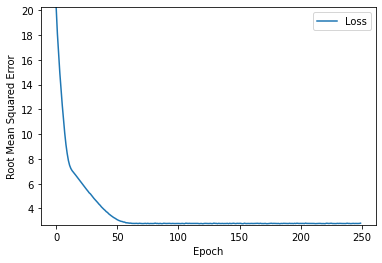

In [12]:
# The following variables are the hyperparameters that need adjusting
learning_rate = 0.03
epochs = 250
batch_size = 25

# Specify the feature and label
my_feature = "Sunshine"
my_label = "Temperature"

my_model = None
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,my_feature, my_label,epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

Predict Temperature

In [13]:
#@title Predictions
def predict_value(n, feature, label):
  """Predict result based on some feature."""

  batch = training_df[feature][100:100 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][100 + i],
                                   training_df[label][100 + i],
                                   predicted_values[i][0] ))
predict_value(10, my_feature, my_label)

feature   label          predicted
  value   value          value
--------------------------------------
   10     14              13
   12     14              13
    0     15              13
    9     16              13
    1     18              13
   11     16              13
   13     17              13
    9     17              13
    9     18              13
    4     18              13


Predicting power isn't great, so let's try a Synthetic feature. we also split the dataset into training and validation datasets using 80/20 ratio.

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


8/8 [==============================] - 1s 6ms/step - loss: 280.3456 - root_mean_squared_error: 16.7435
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 211.3884 - root_mean_squared_error: 14.5392
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 166.9647 - root_mean_squared_error: 12.9215
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 131.0931 - root_mean_squared_error: 11.4496
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 101.3260 - root_mean_squared_error: 10.0661
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 76.4509 - root_mean_squared_error: 8.7436
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 55.9861 - root_mean_squared_error: 7.4824
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 39.7298 - root_mean_squared_error: 6.3032
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 27.1518 - root_mean_squa

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


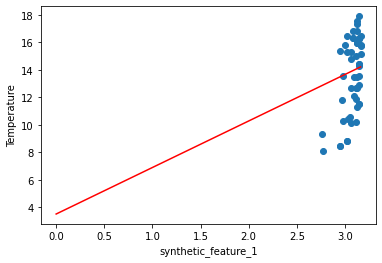

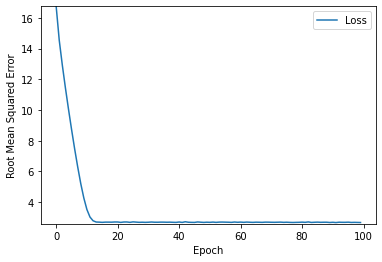

feature   label          predicted
  value   value          value
--------------------------------------
    3     14              14
    3     14              14
    3     15              14
    3     16              14
    3     18              14
    3     16              14
    3     17              14
    3     17              14
    3     18              14
    3     18              14
    3     18              14
    3     19              14
    3     19              14
    3     17              14
    3     16              14


In [14]:
# Define a synthetic feature
training_df["synthetic_feature_1"] = abs(training_df["Humidity"]**0.5)
training_df["synthetic_feature_2"] = abs(training_df["Humidity"] + training_df["Cloud"])
training_df["synthetic_feature_3"] = abs(training_df["Humidity"] + training_df["Cloud"] + training_df["Windspeed"])

my_feature = "synthetic_feature_1"
learning_rate = 0.05
epochs = 100
batch_size = 25

my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,my_feature, my_label,epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)
predict_value(15, my_feature, my_label)

Try Correlation Matrix

In [15]:
# Generate a correlation matrix.
training_df.corr()

,Temperature,Rainfall,Sunshine,Windspeed,Gust_kn,Humidity,Cloud,Visibility,Pressure,Wind_Direction,Max_Gust,synthetic_feature_1,synthetic_feature_2,synthetic_feature_3
Temperature,1.0,-0.1,0.1,0.2,0.1,0.4,0.3,-0.3,0.1,0.1,-0.0,0.4,0.3,0.3
Rainfall,-0.1,1.0,-0.3,0.4,0.4,0.1,0.3,-0.2,-0.5,-0.1,-0.2,0.1,0.3,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
synthetic_feature_2,0.3,0.3,-0.6,0.4,0.3,0.7,1.0,-0.6,-0.3,0.2,0.0,0.7,1.0,0.7
synthetic_feature_3,0.3,0.4,-0.3,0.9,0.8,0.4,0.7,-0.5,-0.5,0.0,-0.1,0.4,0.7,1.0
